# Ape in (buy the latest token)

This is an example automated trading strategy how to buy in to all tthe latest tokens.

This can act as a real strategy, but not recommended.

* This strategy is based on [QSTrader](https://github.com/mhallsmoore/qstrader/) backtesting engine integration.

* The trading universe is all DEX trading pairs. To speed up the simulation in this notebook, we limit the trading strategy to a tokens that meet the certain criteria. Note that you should not do this for the real backtesting, as this induces survivorship bias.

* The trading strategy is a multi-asset strategy that rebalances the portfolio daily.

* For each day, the strategy checks newly available tokens that have come to the markets.

* When the tokens cross the liquidity threshold (have enough liquidity) the strategy buys those tokens, by selling the tokens from the previous day and equally balancing the generated cash in hand across all the tokens of the day.

* The strategy sells the tokens on the following day - the sell signal is 1 day hold.

* There is a high cash buffer of 50%, as the strategy is deemed to make a lot of unsuccessful picks.

* This is a simplified example strategy that ignores loss of trade balance due to slippage, currency conversions, etc.

* The backtest simulation takes some minutes to run. We display the progress using an interactive [tqdm](https://github.com/tqdm/tqdm) progress bar.

## Creating a dataset client

First let's import libraries and initialise our dataset client.

In [1]:
try:
    import capitalgram
except ImportError:
    !pip install -e git+https://github.com/miohtama/capitalgram-onchain-dex-quant-data.git#egg=capitalgram
    import site
    site.main()

from capitalgram.client import Capitalgram

client = Capitalgram.create_jupyter_client()

Started Capitalgram in Jupyter notebook environment, configuration is stored in /Users/mikkoohtamaa/.capitalgram


## Strategy and backtesting parameters

Here we define all parameters that affect the backtest outcome.

In [ ]:
import pandas as pd

# The starting date of the backtest
# Note: At the moment, due to QsTrader internal limitation,
# we define this as NYSE UTC trading hours
start = pd.Timestamp('2020-10-01 14:30:00')

# The ending date of the backtest
end = pd.Timestamp('2021-01-08 23:59:00')

# Start backtesting with $10k in hand
initial_cash = 10_000

# Prefiltering to limit the pair set to speed up computations
# How many USD all time buy volume the pair must have had
# to be included in the backtesting
prefilter_min_buy_volume = 5_000_000

# When this USD threshold of bonding curve liquidity provided is reached,
# we ape in to the token on a daily close.
min_liquidity = 250_000

# How many tokens we can hold in our portfolio
# If there are more new tokens coming to market per day,
# we just ignore those with less liquidity
max_assets_per_portfolio = 5

# How many % of all value we hold in cash all the time,
# so that we can sustain hits
cash_buffer = 0.33

## Setting up logging

QStrader and Capitalgram use Python logging facilitiese with different logging levels to allow you diagnose any issues with the strategy. We set up logging here so that all `INFO` level messages are outputted.

[Here is a tutorial how to use Python logging framework with Jupyter Notebook](https://towardsdatascience.com/how-to-setup-logging-for-your-python-notebooks-in-under-2-minutes-2a7ac88d723d).

In [2]:
import sys
import logging

# Create a Python logger
logger = logging.getLogger("Notebook")

logging.basicConfig(stream=sys.stdout, level=logging.INFO)

logging.info("Logging has been set up")

INFO:root:Logging has been set up


## Creating the trading universe

We take all trading pairs registered on Capitalgram (as the writing of this all Uniswap v2 compatible exchanges).
As the number of trading pairs is very high (50k+).
Most of these trading pairs are random noise and crap.
We reduce the number of trading pairs to speed up the backtest simulation, but this also introduce some
survivorship bias.

In [3]:
from capitalgram.frameworks.qstrader import prepare_candles_for_qstrader
from capitalgram.liquidity import GroupedLiquidityUniverse
from capitalgram.pair import PandasPairUniverse
from capitalgram.timebucket import TimeBucket
from capitalgram.candle import GroupedCandleUniverse
from capitalgram.exchange import ExchangeUniverse

def prefilter_pairs(all_pairs_dataframe: pd.DataFrame) -> pd.DataFrame:
    """Get rid of pairs that we definitely are not interested in.

    This will greatly speed up the later backtesting computations, as we do not need to
    calculate the opening volumes for thousands of pairs.

    Note that may induce survivorship bias - we use thiws mainly
    to ensure the example strategy completes fast enough.
    """
    pairs: pd.DataFrame = all_pairs_dataframe.loc[
        (all_pairs_dataframe['buy_volume_all_time'] > prefilter_min_buy_volume)  # 500k min buys
    ]
    return pairs


exchange_universe = client.fetch_exchange_universe()

# Decompress the pair dataset to Python map
columnar_pair_table = client.fetch_pair_universe()

# Make our universe 40x smaller and faster to compute
filtered_pairs = prefilter_pairs(columnar_pair_table.to_pandas())

# Make the trading pair data easily accessible
pair_universe = PandasPairUniverse(filtered_pairs)
wanted_pair_ids = pair_universe.get_all_pair_ids()

# Get daily candles as Pandas DataFrame
all_candles = client.fetch_all_candles(TimeBucket.d1).to_pandas()
all_candles = all_candles.loc[all_candles["pair_id"].isin(wanted_pair_ids)]
candle_universe = GroupedCandleUniverse(prepare_candles_for_qstrader(all_candles), timestamp_column="Date")

all_liquidity = client.fetch_all_liquidity_samples(TimeBucket.d1).to_pandas()
all_liquidity = all_liquidity.loc[all_liquidity["pair_id"].isin(wanted_pair_ids)]
all_liquidity = all_liquidity.set_index(all_liquidity["timestamp"])
liquidity_universe = GroupedLiquidityUniverse(all_liquidity)

logger.info("Datafeeds set up. We have %d pairs, %d candles, %d liquidity samples",
            pair_universe.get_count(),
            candle_universe.get_candle_count(),
            liquidity_universe.get_sample_count())

INFO:Notebook:Datafeeds set up. We have 1633 pairs, 349168 candles, 350704 liquidity samples


## Creating the strategy

Here is the core of our strategy: alpha model.

* We create an alpha signal source `LiquidityThresholdReachedAlphaModel` for the strategy

* Our backtesting signal source uses "the daily new token reaching the target liquidity" as the buy signal

* [Read QSTrader documentation how QSTrader itself works](https://www.quantstart.com/qstrader/).

In [4]:
from typing import Dict

from qstrader.alpha_model.alpha_model import AlphaModel

def update_pair_liquidity_threshold(
        now_: pd.Timestamp,
        threshold: float,
        reached_state: dict,
        pair_universe: PandasPairUniverse,
        liquidity_universe: GroupedLiquidityUniverse) -> dict:
    """Check which pairs reach the liquidity threshold on a given day.

    :param threshold: Available liquidity, in US dollar

    :return: Dict of pair ids who reached the liquidity threshold and how much liquidity they had
    """

    new_entries = {}

    # QSTrader carries hours in its timestamp like
    # Timestamp('2020-10-01 14:30:00+0000', tz='UTC')
    # as it follows NYSE market open and close timestamps.
    # Capitalgram candle timestamps are in days and mightnight, so we fix it here.
    ts = pd.Timestamp(now_.date())

    for pair_id in pair_universe.get_all_pair_ids():

        # Skip pairs we know reached liquidity threshold earlier
        if pair_id not in reached_state:
            # Get the todays liquidity
            liquidity_samples = liquidity_universe.get_samples_by_pair(pair_id)
            # We determine the available liquidity by the daily open
            try:
                liquidity_today = liquidity_samples["open"][ts]
            except KeyError:
                liquidity_today = 0

            if liquidity_today >= threshold:
                reached_state[pair_id] = now_
                new_entries[pair_id] = liquidity_today

    return new_entries


class LiquidityThresholdReachedAlphaModel(AlphaModel):
    """
    A simple AlphaModel that provides a single scalar forecast
    value for each Asset in the Universe.

    Parameters
    ----------
    signal_weights : `dict{str: float}`
        The signal weights per asset symbol.
    universe : `Universe`, optional
        The Assets to make signal forecasts for.
    data_handler : `DataHandler`, optional
        An optional DataHandler used to preserve interface across AlphaModels.
    """

    def __init__(
            self,
            exchange_universe: ExchangeUniverse,
            pair_universe: PandasPairUniverse,
            candle_universe: GroupedCandleUniverse,
            liquidity_universe: GroupedLiquidityUniverse,
            min_liquidity,
            max_assets_per_portfolio,
            data_handler=None
    ):
        self.exchange_universe = exchange_universe
        self.pair_universe = pair_universe
        self.candle_universe = candle_universe
        self.liquidity_universe = liquidity_universe
        self.data_handler = data_handler
        self.min_liquidity = min_liquidity
        self.max_assets_per_portfolio = max_assets_per_portfolio
        self.liquidity_reached_state = {}

    def construct_shopping_basked(self, dt: pd.Timestamp, new_entries: dict) -> Dict[int, float]:
        """Construct a pair id """

        # Sort entire by volume
        sorted_by_volume = sorted(new_entries.items(), key=lambda x: x[1], reverse=True)

        # Weight all entries equally based on our maximum N entries size
        pick_count = min(len(sorted_by_volume), self.max_assets_per_portfolio)

        ts = pd.Timestamp(dt.date())

        if pick_count:
            weight = 1.0 / pick_count
            picked = {}
            for i in range(pick_count):
                pair_id, vol = sorted_by_volume[i]

                # An asset may have liquidity added, but not a single trade yet (EURS-USDC on 2020-10-1)
                # Ignore them, because we cannot backtest something with no OHLCV data
                candles = self.candle_universe.get_candles_by_pair(pair_id)

                # Note daily bars here, not open-close bars as internally used by QSTrader
                if ts not in candles["Close"]:
                    name = self.translate_pair(pair_id)
                    logger.warning("Tried to trade too early %s at %s", name, ts)
                    continue

                picked[pair_id] = weight

            return picked

        # No new feasible assets today
        return {}

    def translate_pair(self, pair_id: int) -> str:
        """Make pari ids human readable for logging."""
        pair_info = self.pair_universe.get_pair_by_id(pair_id)
        return pair_info.get_friendly_name(self.exchange_universe)

    def __call__(self, dt) -> Dict[int, float]:
        """
        Produce the dictionary of scalar signals for
        each of the Asset instances within the Universe.

        Parameters
        ----------
        dt : `pd.Timestamp`
            The time 'now' used to obtain appropriate data and universe
            for the the signals.

        Returns
        -------
        `dict{str: float}`

            The Asset symbol keyed scalar-valued signals.
        """

        # Refresh which cross the liquidity threshold today
        new_entries = update_pair_liquidity_threshold(
            dt,
            self.min_liquidity,
            self.liquidity_reached_state,
            self.pair_universe,
            self.liquidity_universe
        )
        logger.debug("New entries coming to the market %zs %s", dt, new_entries)
        picked = self.construct_shopping_basked(dt, new_entries)

        if picked:
            logger.debug("On day %s our picks are", dt)
            for pair_id, weight in picked.items():
                logger.debug("    %s: %f", self.translate_pair(pair_id), weight)
        else:
            logger.debug("On day %s there is nothing new interesting at the markets", dt)
        return picked

logger.info("Alpha model created")

INFO:Notebook:Alpha model created


## Setting up the strategy backtest

We have alpha model and trading universe set up, so next we will create a backtest simulation
where we feed all the data we set up for the backtest session.

In [5]:
from qstrader.asset.universe.static import StaticUniverse
from qstrader.data.backtest_data_handler import BacktestDataHandler
from qstrader.simulation.event import SimulationEvent
from qstrader.simulation.everyday import EverydaySimulationEngine
from qstrader.trading.backtest import BacktestTradingSession
from capitalgram.frameworks.qstrader import CapitalgramDataSource

data_source = CapitalgramDataSource(exchange_universe, pair_universe, candle_universe)

strategy_assets = list(data_source.asset_bar_frames.keys())
strategy_universe = StaticUniverse(strategy_assets)

data_handler = BacktestDataHandler(strategy_universe, data_sources=[data_source])

# Construct an Alpha Model that simply provides a fixed
# signal for the single GLD ETF at 100% allocation
# with a backtest that does not rebalance
strategy_alpha_model = LiquidityThresholdReachedAlphaModel(
    exchange_universe,
    pair_universe,
    candle_universe,
    liquidity_universe,
    min_liquidity,
    max_assets_per_portfolio)


strategy_backtest = BacktestTradingSession(
    start,
    end,
    strategy_universe,
    strategy_alpha_model,
    initial_cash=initial_cash,
    rebalance='daily',
    long_only=True,  # Spot markets do not support shorting
    cash_buffer_percentage=cash_buffer,
    data_handler=data_handler,
    simulation_engine=EverydaySimulationEngine(start, end)
)

logger.info("Strategy backtest set up")

Initialising simulated broker "Backtest Simulated Broker Account"...
INFO:qstrader.broker.portfolio.portfolio:(2020-10-01 14:30:00) Portfolio "000001" instance initialised
INFO:qstrader.broker.portfolio.portfolio:(2020-10-01 14:30:00) Funds subscribed to portfolio "000001" - Credit: 0.00, Balance: 0.00
(2020-10-01 14:30:00) - portfolio creation: Portfolio "000001" created at broker "Backtest Simulated Broker Account"
INFO:qstrader.broker.portfolio.portfolio:(2020-10-01 14:30:00) Funds subscribed to portfolio "000001" - Credit: 10000.00, Balance: 10000.00
(2020-10-01 14:30:00) - subscription: 10000.00 subscribed to portfolio "000001"
INFO:Notebook:Strategy backtest set up


## Running the QSTrader strategy

Next we run the strategy. This can take potentially many minutes, as it crunches through some data.

The notebook displays a HTML progress bar is displayed during the run, and the estimation when the simulation
is complete.

In [6]:
from tqdm.autonotebook import tqdm

# Supress excessive qstrader logging output
logging.getLogger("qstrader").setLevel(logging.WARNING)

logger.info("Running the strategy")

max_events = len(strategy_backtest.fetch_simulation_events())

# Run the test with a nice progress bar
with tqdm(total=max_events) as progress_bar:
    def progress_callback(idx: int, dt: pd.Timestamp, evt: SimulationEvent):
        progress_bar.set_description(f"Simulation at day {dt.date()}")
        progress_bar.update(idx)

    strategy_backtest.run(progress_callback=progress_callback)

logger.info("Backtest complete")

INFO:Notebook:Running the strategy


  0%|          | 0/400 [00:00<?, ?it/s]

INFO:Notebook:Backtest complete


## Analyzing the strategy results

After the strategy is run, we will display charts and statistics on its performance.

In [7]:
from capitalgram.frameworks.qstrader import analyse_portfolio

# "000001" is the default name given for the default portfolio by QSTrader
portfolio = strategy_backtest.broker.portfolios["000001"]
trade_analysis = analyse_portfolio(portfolio.history)

### Summary of trades

This displays number of trades, how many we won and lost.

In [8]:
from IPython.core.display import HTML
from IPython.display import display

from capitalgram.analysis.tradeanalyzer import TradeSummary

cash_left = strategy_backtest.broker.get_total_portfolio_cash_balances()
summary: TradeSummary = trade_analysis.calculate_summary_statistics(initial_cash, cash_left)

display(HTML(summary.to_dataframe().to_html(header=False)))

Cash at start,"$10,000.00"
Value at end,"$1,814.62"
Trade win percent,38%
Total trades done,189
Won trades,71
Lost trades,117
Zero profit trades,1
Positions open at the end,4
Realised profit and loss,"$-8,185.38"
Portfolio unrealised value,"$1,091.04"
Cash left at the end,$723.59


### Tearsheet chart

Tearsheet displays the portfolio profit and risk over the time.

Plotting the tearsheet...


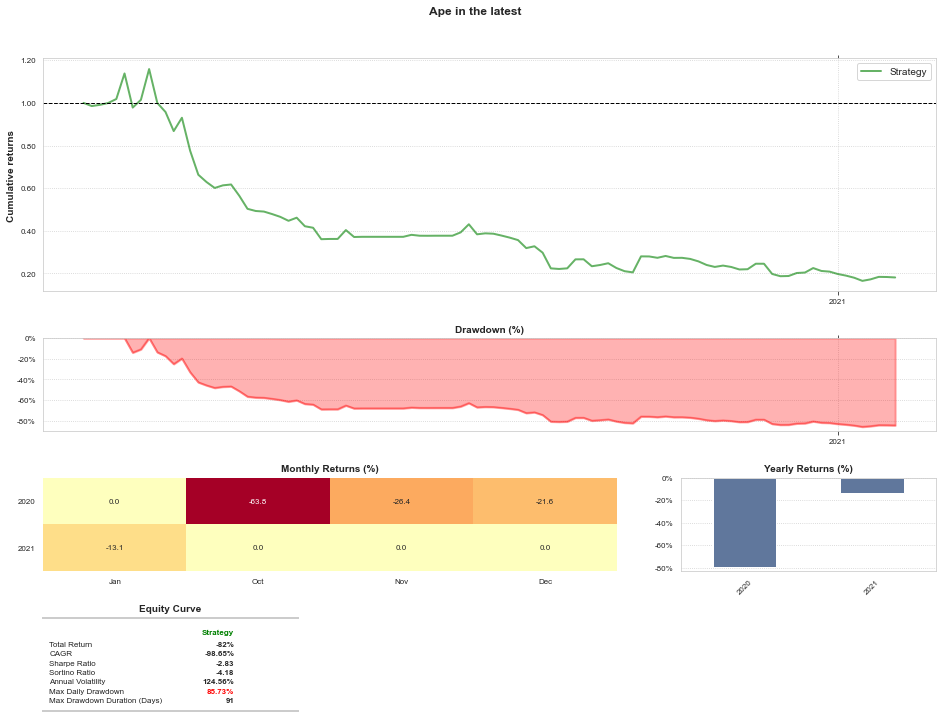

In [9]:
from qstrader.statistics.tearsheet import TearsheetStatistics

tearsheet = TearsheetStatistics(
    strategy_equity=strategy_backtest.get_equity_curve(),
    title=f'Ape in the latest'
)

tearsheet.plot_results()

### Trading timeline

Trading timeline displays individual trades the strategy made.

In [10]:
from capitalgram.analysis.tradeanalyzer import expand_timeline

# Generate raw timeline of position open and close events
timeline = trade_analysis.create_timeline()

# Expand timeline with human-readable exchange and pair symbols
expanded_timeline = expand_timeline(exchange_universe, pair_universe, timeline)

# Do not truncate the row output
pd.reset_option('display.max_rows')

display(expanded_timeline)

,exchange,base,quote,price,event,opened_value,profit,profit_pct,closed_value,won,lost
timestamp,,,,,,,,,,,
2020-10-02 14:30:00,Uniswap v2,WETH,USDC,352.915741,Opened,1411.662964,,,,,
2020-10-05 14:30:00,Uniswap v2,WETH,USDC,352.969299,Closed,,0.214233,0.000152,1411.877197,1.0,
2020-10-02 14:30:00,Uniswap v2,WETH,DAI,347.183807,Opened,1388.735229,,,,,
2020-10-05 14:30:00,Uniswap v2,WETH,DAI,347.808258,Closed,,2.497803,0.001799,1391.233032,1.0,
2020-10-02 14:30:00,Uniswap v2,WETH,WBTC,351.676819,Opened,1406.707275,,,,,
...,...,...,...,...,...,...,...,...,...,...,...
2021-01-08 14:30:00,Uniswap v2,BBR,WETH,8.664709,Closed,,10.624034,0.038589,285.9354,1.0,
2021-01-08 14:30:00,Uniswap v2,BART,WETH,0.028472,Opened,257.440816,,,,,
2021-01-08 14:30:00,Uniswap v2,OUSD,USDT,1.000229,Opened,274.062648,,,,,
